<a href="https://colab.research.google.com/github/microprediction/winningnotebooks/blob/main/Normalish_Horse_Race.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Python code please to plot three different exponential distributions with hazard  rate paramters. make the hazard rate parameters add to 1. Then also plot simulations of the same in three different colours in density mode so that they snugly fit into the densities plotted. Then, on a second plot, also plot three density histograms of each set of three simulations but with each point raised to the 1/4th power. Create a density estimate for all three and show that overlaid. Calculate the means and variances of the distributions in the second plot and show them on the plot somehow.

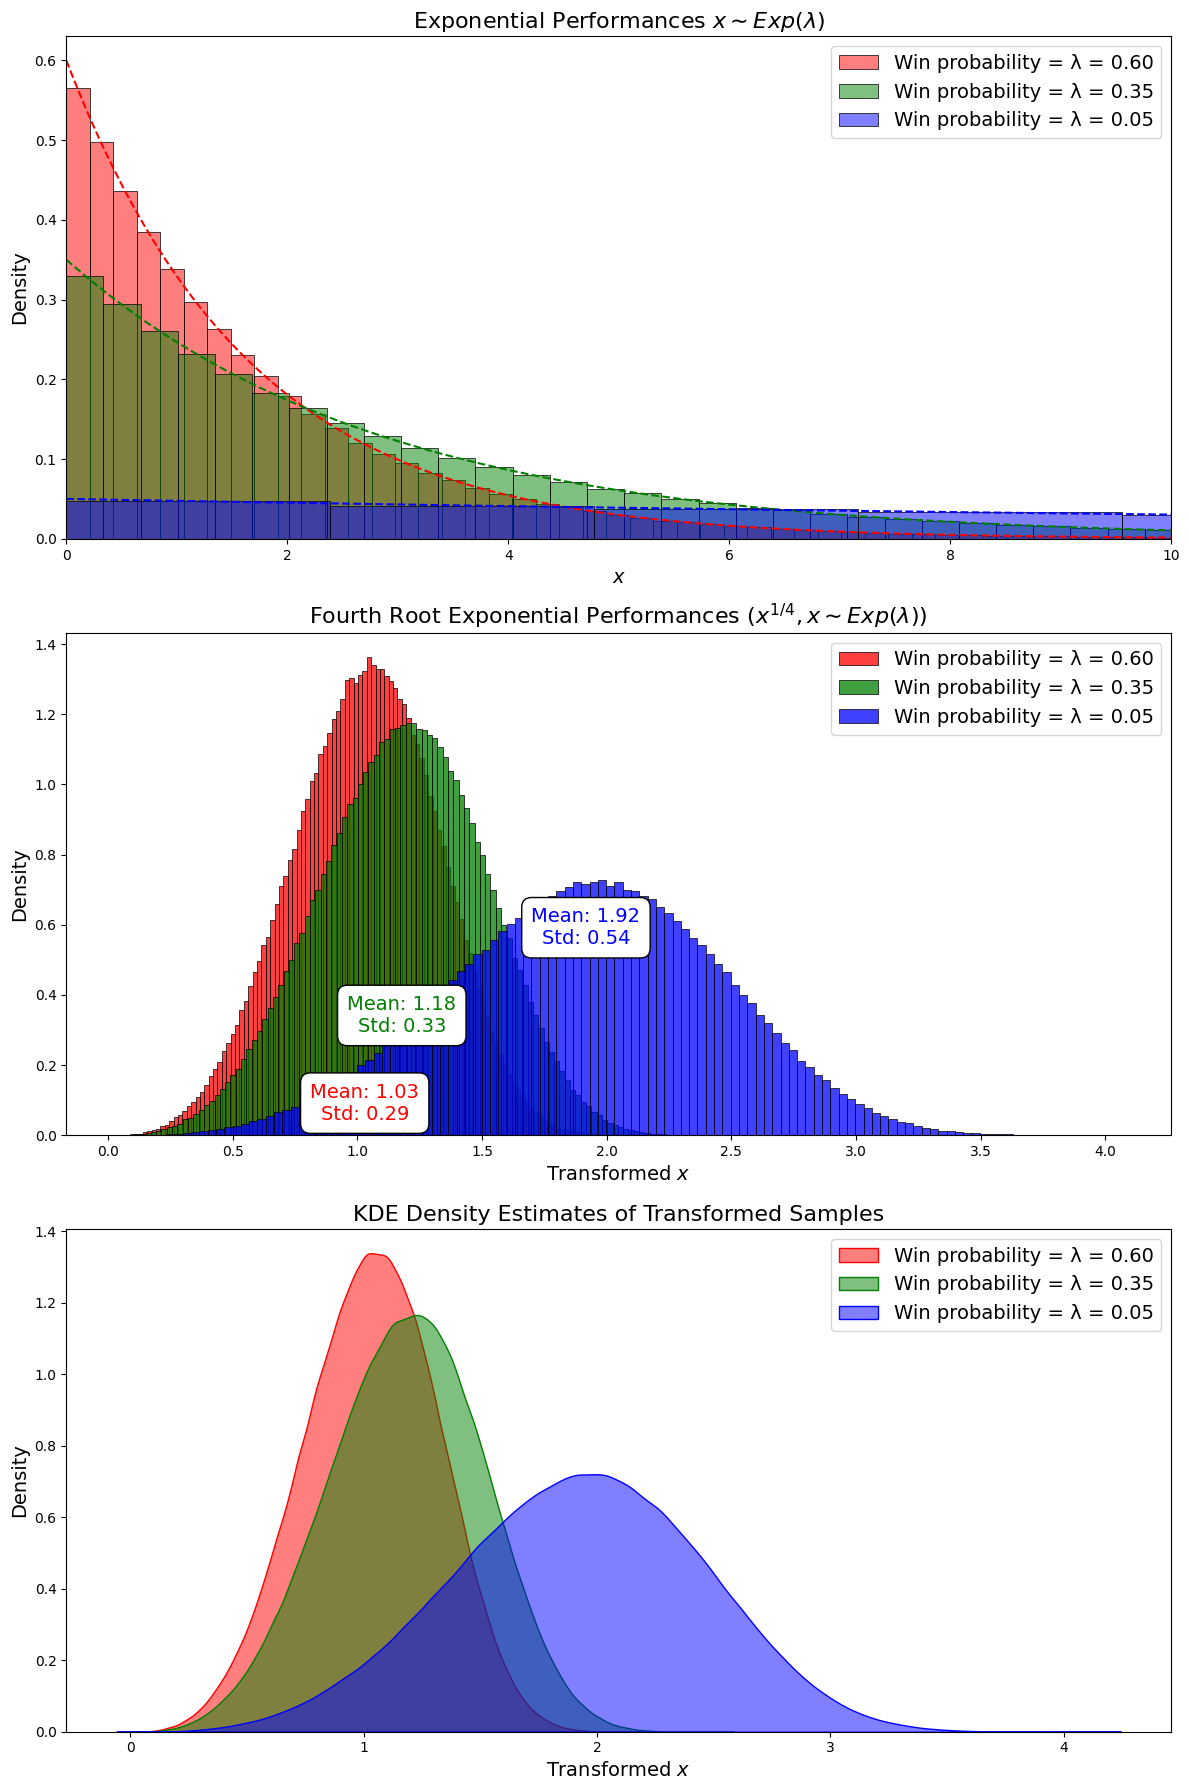

In [72]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import expon

BINS = 120

# Set the hazard rate parameters that sum to 1
hazard_rates = np.array([0.6, 0.35, 0.05])

# Ensure the sum of hazard rates equals 1
hazard_rates /= np.sum(hazard_rates)

# Number of samples for each simulation
n_samples = 1000000

# Define colors for the distributions
colors = ['r', 'g', 'b']

# Set up the figure for the plots
fig, ax = plt.subplots(3, 1, figsize=(12, 18))  # Increased figure size for readability

# First plot: Density histograms and the corresponding exponential PDFs
x_max = 10
x = np.linspace(0, x_max, 1000)

for hazard, color in zip(hazard_rates, colors):
    # Simulate from the distribution
    samples = np.random.exponential(1 / hazard, n_samples)

    # Plot the histogram (density mode) for each set of simulations
    sns.histplot(samples, color=color, kde=False, stat='density', ax=ax[0], label=f'Win probability = λ = {hazard:.2f}', bins=BINS, alpha=0.5)

    # Plot the theoretical PDF for the exponential distribution
    pdf = hazard * np.exp(-hazard * x)
    ax[0].plot(x, pdf, color=color, linestyle='--')

# Set x-axis range for the first plot
ax[0].set_xlim([0, x_max])

# LaTeX in the title and increased font size for the title and labels
ax[0].set_title(r'Exponential Performances $x \sim Exp(\lambda)$', fontsize=16)
ax[0].set_xlabel(r'$x$', fontsize=14)
ax[0].set_ylabel(r'Density', fontsize=14)

# Adjust legend size
ax[0].legend(fontsize=14)

# Second plot: Transformed histograms
means = []
std_devs = []
label_y_offset = 0.15  # Start with a vertical offset for the labels

for i, (hazard, color) in enumerate(zip(hazard_rates, colors)):
    # Simulate from the distribution again
    samples = np.random.exponential(1 / hazard, n_samples)

    # Apply the transformation (raise to the 1/4th power)
    transformed_samples = samples ** (1/4)

    # Plot the histogram (density mode) for the transformed samples
    sns.histplot(transformed_samples, color=color, kde=False, stat='density', ax=ax[1], label=f'Win probability = λ = {hazard:.2f}', bins=BINS)

    # Calculate mean and standard deviation for the transformed samples
    mean = np.mean(transformed_samples)
    std_dev = np.std(transformed_samples)
    means.append(mean)
    std_devs.append(std_dev)

    # Annotate mean and standard deviation with larger font
    ax[1].annotate(f'Mean: {mean:.2f}\nStd: {std_dev:.2f}',
                   xy=(mean, label_y_offset), color=color, fontsize=14,  # Increased font size to 14
                   ha='center', va='top', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))

    label_y_offset += 0.25  # Increment the offset for the next label

# LaTeX in the title and increased font size for the title and labels
ax[1].set_title(r'Fourth Root Exponential Performances ($x^{1/4}, x \sim Exp(\lambda)$)', fontsize=16)
ax[1].set_xlabel(r'Transformed $x$', fontsize=14)
ax[1].set_ylabel(r'Density', fontsize=14)

# Adjust legend size
ax[1].legend(fontsize=14)

# Third plot: KDE density estimates of the transformed samples
for hazard, color in zip(hazard_rates, colors):
    # Simulate from the distribution again
    samples = np.random.exponential(1 / hazard, n_samples)

    # Apply the transformation (raise to the 1/4th power)
    transformed_samples = samples ** (1/4)

    # Plot density estimate for the transformed samples
    sns.kdeplot(transformed_samples, color=color, fill=True, alpha=0.5, ax=ax[2], label=f'Win probability = λ = {hazard:.2f}')

# LaTeX in the title and increased font size for the title and labels
ax[2].set_title(r'KDE Density Estimates of Transformed Samples', fontsize=16)
ax[2].set_xlabel(r'Transformed $x$', fontsize=14)
ax[2].set_ylabel(r'Density', fontsize=14)

# Adjust legend size
ax[2].legend(fontsize=14)

# Show the plots
plt.tight_layout()
plt.show()


In [27]:
!pip install winning

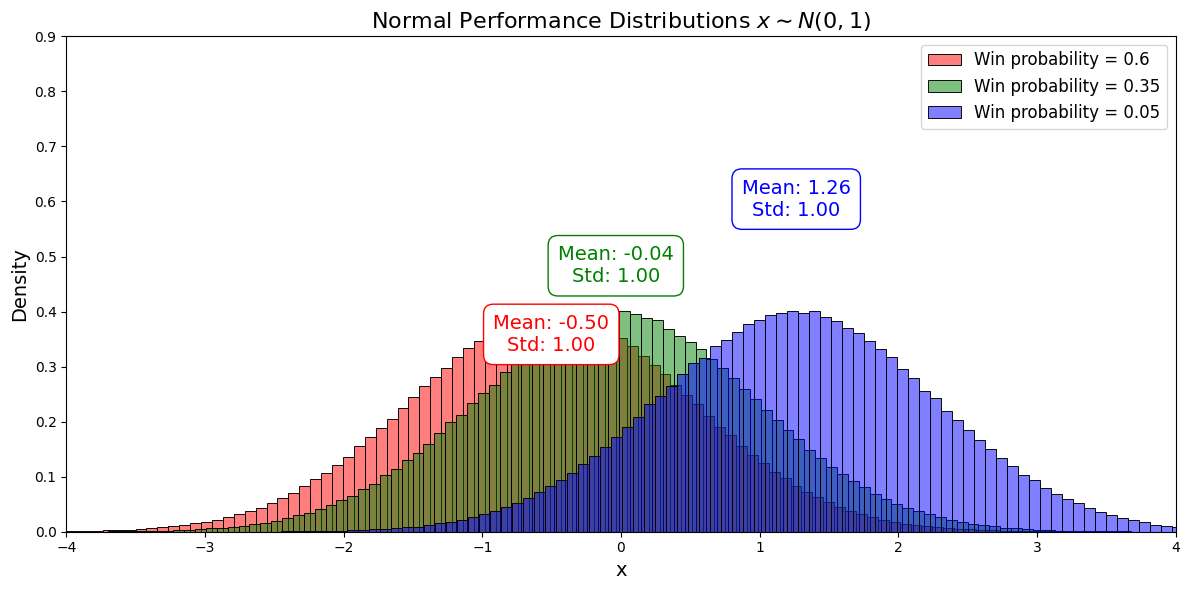

In [74]:
from winning.std_calibration import centered_std_density
from winning.lattice_calibration import dividend_implied_ability
import numpy as np
import matplotlib.pyplot as plt
from winning.lattice_plot import densitiesPlot
from winning.lattice import skew_normal_density
import seaborn as sns

# Choose the length of the lattice, which is 2*L+1
L = 600


# Choose the unit of discretization
unit = 0.01

# Step 1. The unit is used to create an approximation of a density, here N(0,1) for simplicity
density = centered_std_density(L=L, unit=unit)

# Step 2. We set winning probabilities, most commonly represented in racing as inverse probabilities ('dividends')
hazard_rates = [0.6, 0.35, 0.05]  # Example hazard rates
dividends = [1/h for h in hazard_rates]  # Convert hazard rates to dividends (1/h)

# Step 3. The algorithm implies relative ability (i.e., how much to translate the performance distributions)
abilities = dividend_implied_ability(dividends=dividends, density=density, nan_value=2000, unit=unit)

# Step 4. Generate skew-normal densities for each ability
densities = [skew_normal_density(L=L, unit=unit, loc=a, a=0, scale=1.0) for a in abilities]

# Step 5. Generate samples from densities for plotting histograms
n_samples = 1000000
colors = ['r', 'g', 'b']  # Adjust number of colors based on number of abilities
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

# Tighten x-axis and y-axis limits to remove unnecessary white space
ax.set_xlim([-4, 4])  # Adjust x-axis limit to be more focused
ax.set_ylim(0, 0.9)  # Adjust y-axis limit to reduce white space

# Use dynamic vertical offsets based on density heights at the mean
for i, (density, ability, color) in enumerate(zip(densities, abilities, colors)):
    # Generate normally distributed samples for the histogram
    samples = np.random.normal(loc=ability, scale=1, size=n_samples)

    # Plot histogram for each distribution
    label = f'Win probability = {hazard_rates[i]}'
    hist_data = sns.histplot(samples, color=color, kde=False, stat='density', bins=BINS, label = label, alpha=0.5)

    # Calculate mean and standard deviation
    mean = np.mean(samples)
    std_dev = np.std(samples)

    # Find the bin height (density) at the mean
    bin_heights, bin_edges = np.histogram(samples, bins=BINS, density=True)
    mean_bin_idx = np.digitize(mean, bin_edges) - 1  # Find bin index where the mean falls
    label_y_position = bin_heights[mean_bin_idx]  # Use the corresponding bin height for the label

    # Adjust y position for better spacing and avoid overlap
    adjusted_y_position = label_y_position + (0.12 * i)  # Increment the y position dynamically

    # Annotate mean and standard deviation with larger font, applying the adjusted y position
    ax.annotate(f'Mean: {mean:.2f}\nStd: {std_dev:.2f}',
                xy=(mean, adjusted_y_position), color=color, fontsize=14,  # Increased font size to 14
                ha='center', va='top', bbox=dict(facecolor='white', edgecolor=color, boxstyle='round,pad=0.5'))

# Title and labels with LaTeX formatting
ax.set_title(r'Normal Performance Distributions $x \sim N(0,1)$', fontsize=16)
ax.set_xlabel(r'x', fontsize=14)
ax.set_ylabel(r'Density', fontsize=14)

# Display legend
ax.legend(fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()
